In [3]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [4]:
PATH_TO_DATA = './data/'
os.listdir(PATH_TO_DATA)

['train_labels.csv']

In [5]:
train_labels_df = pd.read_csv(PATH_TO_DATA + 'train_labels.csv')
print(train_labels_df.shape)
train_labels_df.head()

(585, 2)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [6]:
value_counts = train_labels_df['MGMT_value'].value_counts()
value_counts

1    307
0    278
Name: MGMT_value, dtype: int64

<AxesSubplot:>

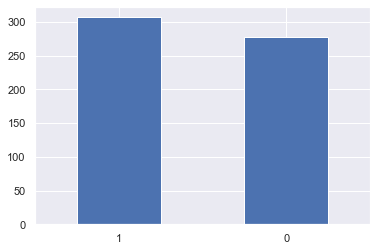

In [9]:
# plt.figure(figsize=(7,5))
value_counts.plot(kind='bar', rot=0)

<AxesSubplot:>

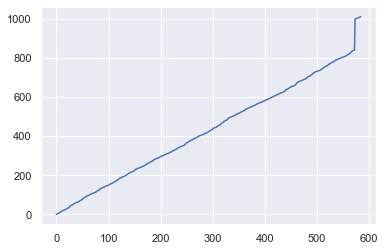

In [12]:
train_labels_df['BraTS21ID'].plot()

# Read images

In [13]:
IMG_SIZE = 512
IMG_PATH_TRAIN = os.path.join(PATH_TO_DATA, 'rsna-brain-tumor-data', 'train')
IMG_PATH_TEST = os.path.join(PATH_TO_DATA, 'rsna-brain-tumor-data', 'test')
IMG_PATH_TRAIN

'./data/rsna-brain-tumor-data/train'

In [14]:
from PIL import Image
import cv2

## Read one image

In [111]:
case_idx = 20
case_id = train_labels_df['BraTS21ID'][case_idx]
# case_id = f'{case_id:05d}'
case_id = f'{case_id:0>5d}'
case_id

'00030'

In [112]:
# - FLAIR
# - T1w
# - T1wCE
# - T2w
MRI_TYPE = 'FLAIR'

images_path = os.path.join(IMG_PATH_TRAIN, case_id, MRI_TYPE)
images_path

'./data/rsna-brain-tumor-data/train/00030/FLAIR'

In [39]:
image_number = 5
image_name = os.listdir(images_path)[image_number]
# sorted(os.listdir(images_path))
image_name

'Image-444.png'

In [40]:
image_path = os.path.join(images_path, image_name)
image_path

'./data/rsna-brain-tumor-data/train/00030/FLAIR/Image-444.png'

In [77]:
image = Image.open(image_path)
np.array(image).shape

(512, 512)

In [75]:
# image

In [76]:
# image = cv2.imread(image_path)
# image.shape

In [72]:
def show_image(image):
    # plt.figure(figsize=(5,5))
    plt.grid(False)
    plt.axis('off')
#     plt.imshow(image)
    plt.imshow(image, cmap='bone') # gray, bone
    plt.show()

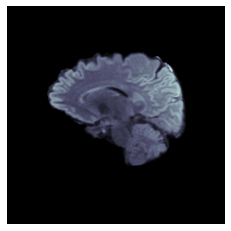

In [78]:
show_image(image)

## PyTorch dataset

In [79]:
from torch.utils.data import Dataset

In [149]:
class Image3DDataset(Dataset):
    def __init__(self, df, path, transform=None):

        self.df = df
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        label = train_labels_df['MGMT_value'][index]
        case_id = train_labels_df['BraTS21ID'][index]
        case_id = f'{case_id:0>5d}'

        # - FLAIR
        # - T1w
        # - T1wCE
        # - T2w
        MRI_TYPE = 'FLAIR'
        
        images_path = os.path.join(IMG_PATH_TRAIN, case_id, MRI_TYPE)

        # name = 'Image-100.png'
        image_names = sorted(os.listdir(images_path), key=lambda name: int(name[6:][:-4]))
        images = []
        
        for image_name in image_names:
            image_path = os.path.join(images_path, image_name)
            image = Image.open(image_path)
            images.append(image)
            
        image_3d = np.stack(images)
            
#         if self.transform:
#             image = self.transform(image)

           
        return image_3d, label

In [150]:
train_dataset = Image3DDataset(train_labels_df, IMG_PATH_TRAIN)
len(train_dataset)

585

In [157]:
image, label = train_dataset[1]
image.shape, label

((67, 512, 512), 1)

In [158]:
def show_image_3d(image_3d):  
    size = 2
    num_images = image_3d.shape[0]
    ncol = 10
    nrow = int(num_images / ncol)
    
    fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * size, nrow * size))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        image = image_3d[i]
        
        ax.imshow(image, cmap='bone')
        ax.axis('off')
     
    plt.show()

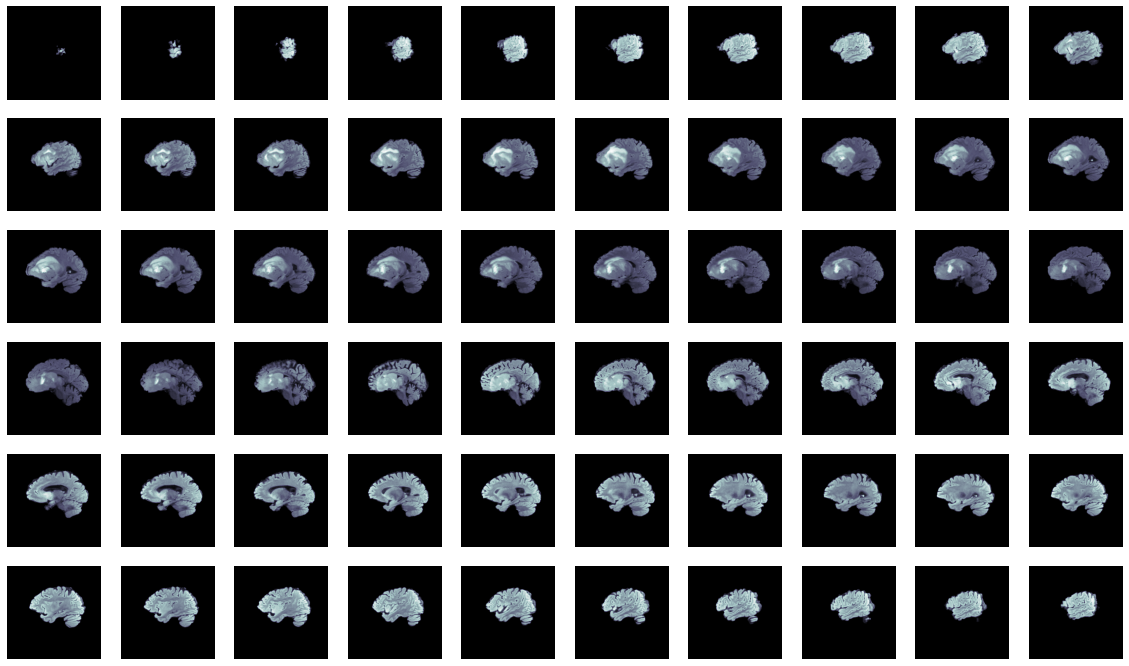

In [159]:
show_image_3d(image)

# Num of images per MRI type

In [160]:
train_labels_df.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [199]:
# 00109 - no FLAIR
# 00123 - no T1w
# 00709 - no FLAIR

print(train_labels_df.shape)
train_labels_df = train_labels_df.drop(train_labels_df[train_labels_df['BraTS21ID'] == 109].index)
train_labels_df = train_labels_df.drop(train_labels_df[train_labels_df['BraTS21ID'] == 709].index)
train_labels_df = train_labels_df.drop(train_labels_df[train_labels_df['BraTS21ID'] == 123].index)
print(train_labels_df.shape)

(583, 6)
(582, 6)


In [200]:
def row_to_mri_type_count(row, mri_type):
    case_id = row['BraTS21ID']
    case_id = f'{case_id:0>5d}'
    images_path = os.path.join(IMG_PATH_TRAIN, case_id, mri_type)   
    count = len(os.listdir(images_path))
       
    return count

In [201]:
MRI_TYPES = ['FLAIR', 'T1w', 'T1wCE', 'T2w']

def get_mri_count():
    for mri_type in MRI_TYPES:
        train_labels_df[f'{mri_type}_count'] = train_labels_df.apply(
            lambda row: row_to_mri_type_count(row, mri_type),
            axis=1
        )
        
get_mri_count()

In [202]:
train_labels_df

,BraTS21ID,MGMT_value,FLAIR_count,T1w_count,T1wCE_count,T2w_count
0,0,1,288,29,86,274
1,2,1,67,27,88,269
2,3,0,71,28,88,285
3,5,1,277,26,83,272
4,6,1,68,28,89,270
...,...,...,...,...,...,...
580,1005,1,21,21,21,21
581,1007,1,114,114,114,114
582,1008,1,45,137,138,47
583,1009,0,22,22,22,22


<AxesSubplot:>

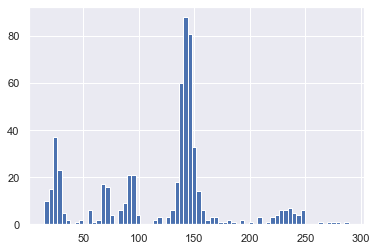

In [226]:
# plt.hist(train_labels_df['FLAIR_count'], bins=100)
# plt.show()

train_labels_df['T1wCE_count'].hist(bins=70)

In [218]:
# train_labels_df['FLAIR_count'].value_counts()

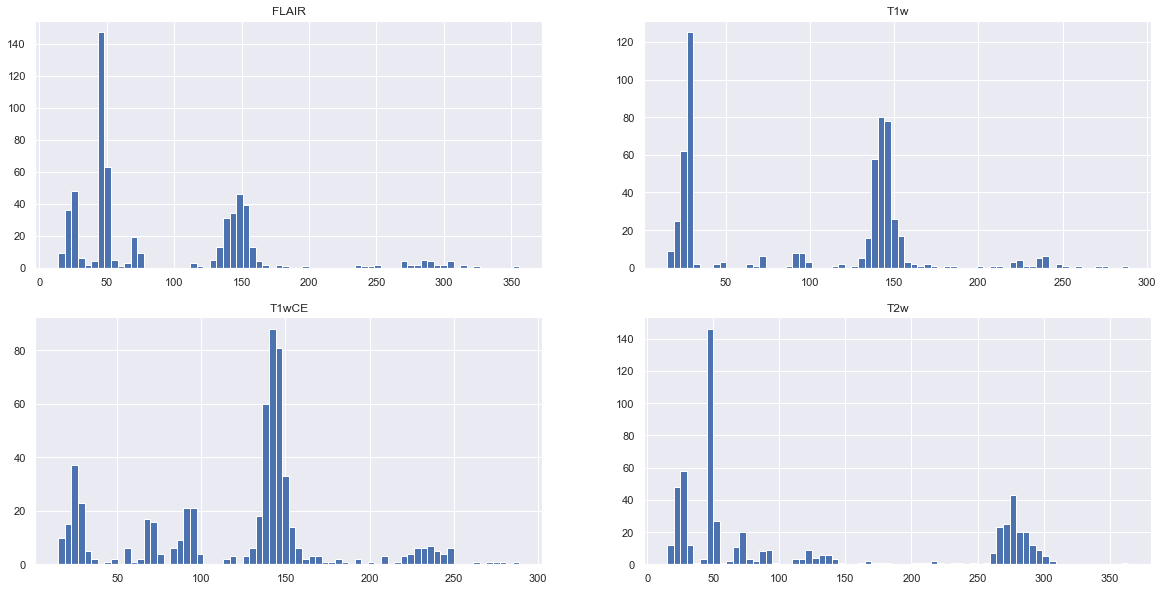

In [225]:
_, axes = plt.subplots(2, 2, figsize=(20,10))

axes = axes.flatten()
    
for i, ax in enumerate(axes):
    mri_type = MRI_TYPES[i]  
     
    ax.set_title(mri_type)
    ax.hist(train_labels_df[f'{mri_type}_count'], bins=70)

# Image sizes